# MPC 
model predictive control for simple pendulum        
inspired by:        
https://github.com/simorxb/MPC-Pendulum-Python-2/blob/main/MPC.py       

The algorithm:
- estimate the state
- do trajectory optimization (dynamics trajopt with linear cost/constraints because we want it to be fast)
- select the first step and exectue
- repeat        


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML, SVG, display
import pydot
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    LeafSystem,
    Linearize,
    RigidTransform,
    RotationMatrix,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
    DirectCollocation,
    FiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    LogVectorOutput,
    MakeFiniteHorizonLinearQuadraticRegulator,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    PiecewisePolynomial,
    PlanarSceneGraphVisualizer,
    SceneGraph,
    SnoptSolver,
    Solve,
    TrajectorySource,
    MathematicalProgram,
    MakeVectorVariable,
    Variable,
    ConstantVectorSource,
    SnoptSolver,
    SolverOptions,
    SolverType,
    PassThrough
)

from pydrake.examples import AcrobotGeometry, AcrobotPlant, PendulumPlant, PendulumState, PendulumGeometry
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from IPython.core.display import Image, display
from underactuated.pendulum import PendulumVisualizer

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


diagram systems:


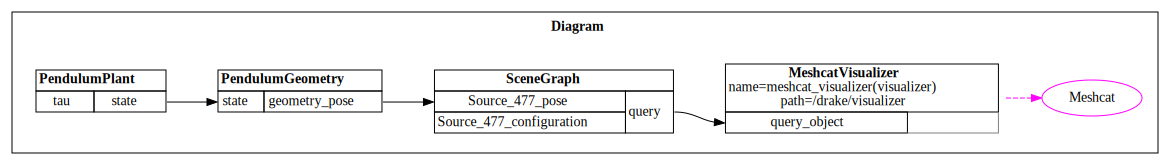

::_ Context (of a Diagram)
---------------------------
2 total continuous states
4 total numeric parameters in 1 groups
2 total abstract parameters

::_::drake/examples/pendulum/PendulumPlant@00005884d960eea0 Context
--------------------------------------------------------------------
Time: 0
States:
  2 continuous states
    0.5   0

Parameters:
  1 numeric parameter groups with
     4 parameters
          1  0.5  0.1 9.81

::_::drake/geometry/SceneGraph@00005884d96baab0 Context
--------------------------------------------------------
Time: 0
Parameters:
  2 abstract parameters

initial [1.0, 2.0]
optimiztion success:  False
optimal cost: 380.64770495817174
(21,)
tau 0.0029465571245353983
initial [0.4543093060182663, -0.8945178617902952]
optimiztion success:  True
optimal cost: 116.90600360778095
(21,)
tau -0.05968633600373385
initial [0.4543093060182663, -0.8945178617902952]
optimiztion success:  True
optimal cost: 116.90600360778095
(21,)
tau -0.05968633600373385
initial [0.45430930

In [5]:
def pend_dircol(N, x_ref, x_initial, x_final):
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()
    print('initial', x_initial)
    max_dt = 0.5
    N * max_dt
    dircol = DirectCollocation(
        plant, # we do not have to explicitly set the dynamics as constraints. It does it by itself here
        context,
        num_time_samples=N,
        minimum_time_step=0.05,
        maximum_time_step=max_dt,
    )
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    torque_limit = 3.0  # N*m.
    u = dircol.input()
    x = dircol.state()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = PendulumState()
    # print(dircol.initial_state())
    # print(initial_state.get_value())
    initial_state.set_theta(x_initial[0])
    initial_state.set_thetadot(x_initial[1])
    prog.AddBoundingBoxConstraint(
        initial_state.get_value(),
        initial_state.get_value(),
        dircol.initial_state(),
    )

    final_state = PendulumState()
    final_state.set_theta(x_final[0])
    final_state.set_thetadot(x_final[1])
    prog.AddBoundingBoxConstraint(
        final_state.get_value(), final_state.get_value(), dircol.final_state()
    )
    # dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0] ** 2 + (x[0] - x_ref[0])**2)
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0, 4.0], [initial_state.get_value(), final_state.get_value()]
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    print('optimiztion success: ', result.is_success() )
    print('optimal cost:', result.get_optimal_cost())
    # return input values
    out = dircol.GetInputSamples(result)
    return out[0]
    
    x_trajectory = dircol.ReconstructStateTrajectory(result)
    # print(dircol.GetSampleTimes(result))
    fig, ax = plt.subplots()

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), 100
            )
        ]
    )

    ax.set_xlabel("$q$")
    ax.set_ylabel("$\dot{q}$")
    ax.plot(x_knots[0, :], x_knots[1, :])
    display(plt.show())

    # Animate the result.
    vis = PendulumVisualizer(show=False)
    ani = vis.animate(x_trajectory)
    display(HTML(ani.to_jshtml()))
    


builder = DiagramBuilder()
pendulum = builder.AddSystem(PendulumPlant())

# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
PendulumGeometry.AddToBuilder(
    builder, pendulum.get_state_output_port(), scene_graph
)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
meshcat.Delete()
meshcat.Set2dRenderMode(
    X_WC=RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0, 1, 0])
)

diagram = builder.Build()
print('diagram systems:')
display(
    SVG(
            pydot.graph_from_dot_data(diagram.GetGraphvizString ())[0].create_svg()
        )
)

simulator = Simulator(diagram)
context = simulator.get_mutable_context() # diagram context

meshcat.AddButton("Stop Simulation")

context.SetContinuousState([0.5, 0])

pendulum_context = pendulum.GetMyMutableContextFromRoot(context)
print(context)


N = 21 # model predictive horizon
time_range = 10.0
dt = 0.1
L = round(time_range/dt)
tau = np.zeros(L)
state = np.zeros((2,L))
x_ref = np.zeros((2,L))
x_initial = [1.0, 2.0]
x_final = [np.pi/2, 0.0]
step = 0
for i in range(L):

    # ---- generate reference point. 
    if step < 5:
        x_ref[0,i] = np.pi
    else:
        x_ref[0,i] = np.pi / 2

    step += dt

    # ----- solve trajopt for next N steps
    tau_traj = pend_dircol(N, x_ref[:,i], x_initial, x_final)
    print(tau_traj.shape)
    # get the first element
    tau[i] = tau_traj[0]
    print('tau', tau[i])

    # ----- run simulation. 
    # extract the state of the next step
    pendulum.GetInputPort("tau").FixValue(pendulum_context, tau[i])
    simulator.AdvanceTo(dt)
    
    # extract new state
    s = pendulum.get_state(pendulum_context)
    state[:,i] = [s[0], s[1]]
    # also we could do:
    # print(pendulum_context.get_state().get_continuous_state().get_vector() )
    
    x_initial = state[:,i].tolist()

    # TODO: to be completed but I get the idea
    # break

print(state)

# Offline behaviour library and onlin mpc

Its a dynamic trajectory optimiztion problem in a loop. With horizon cost and the final cost.
Horizon cost minimized the error between current and a reference trajectory. 
Also we could add min of the input control
Final cost, is termination time.
Decision variables: state and input

We also want a linear dynamic system, because we are solving this in a control loop and we need
fast response.


A good approach that Boston Dynamics uses is to divide the trajectory optimization into two parts:
Offline and Online.         
Offline: we do the heavy nonlinear trajectory optimization with all the constraints. This will be a template representing a behavious. They have a library of these behaviours. 

Online: Then for a given problem a behavior is selected. Then MPC is being used for the same problem but adapting the offline solution for the current environment.

The result of the offline step ($x_{TO}, u_{TO}$) is used in the running cost function as a reference but in a soft constriant manner. Also, the terminal/final cost includes the start and goal.

<img src="./share/onlilne_mpc.png" width=600>

<figure>
<img src="./share/formula.png" width=600>
<figcaption>Offline motion libraries and online MPC for advanced mobility skills by Marko Bjelonic et al </figcaption>
</figure>
